### Overview of the shift between publication and patent documents from target perspective

#### Import modules

In [1]:
import pandas as pd
from collections import defaultdict
import string

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400
sns.set(style='white')

### Loading data files

In [4]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'
RAW_DATA_DIR = '../data/raw'

In [5]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_gene_enumerated_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL3137316,SCHEMBL1707427,US-20140316139-A1,2014-10-23,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"
1,CHEMBL3137316,SCHEMBL1707427,US-20140142316-A1,2014-05-22,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"


In [6]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_gene_enumerated_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL1460470,SCHEMBL14919618,US-20140256767-A1,2014-09-11,C07D 401/14,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"
1,CHEMBL1460470,SCHEMBL14919618,US-20180148408-A1,2018-05-31,C07D 209/48,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"


Drop patents with no assignee names

In [7]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 10), (76321, 10))

In [8]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 10)

In [9]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 10)

### Ranking of targets based on patent documents

In [10]:
def create_target_rank(df: pd.DataFrame, genes_of_interest: str):
    """Create target dataframe based on the no.of patent documents and publications linked."""
    
    # Get patent data
    patent_dict = defaultdict(lambda: defaultdict(set))
    for patent_idx, date, assignee, genes in df[['patent_id', 'date', 'assignee', 'genes']].values:
        year = date.split("-")[0]
        
        for gene in genes.split(', '):
            patent_dict[gene][year].add(patent_idx)
          
    patent_dict = patent_dict[genes_of_interest]  # dictionary of year-patent count for gene of interest  
            
    # Get publication data
    publication_df = pd.read_csv(f'{RAW_DATA_DIR}/target_publication_year.tsv', sep='\t')
    
    publication_df = publication_df.loc[publication_df['gene'] == genes_of_interest]
    publication_df.drop(columns=['gene'], inplace=True)
    publication_df.set_index('Year', inplace=True)
    publication_dict = publication_df.to_dict()['Count']
    
    pat_data = []
    pub_data = []
    
    years = set(patent_dict.keys()).union(set(publication_dict.keys()))
    
    for year in years:
        # Get total patent count
        if year in patent_dict:
            patent_count = len(patent_dict[year])
        else:
            patent_count = 0
            
        pub_count = publication_dict.get(year, 0)
        
        # Source based addition
        pat_data.append({
            'year': int(year),
            'count': patent_count,
            'source': 'Patent'
        })
        
        pub_data.append({
            'year': int(year),
            'count': pub_count,
            'source': 'Publication'
        })
        
    pat_df = pd.DataFrame(pat_data)
    pub_df = pd.DataFrame(pub_data)
    
    # Normalizing the counts
    pat_df['count'] = (pat_df['count'] - pat_df['count'].min()) / (pat_df['count'].max()-pat_df['count'].min())
    pub_df['count'] = (pub_df['count'] - pub_df['count'].min()) / (pub_df['count'].max()-pub_df['count'].min())
    
    # Merging the two
    df = pd.concat([pat_df, pub_df], ignore_index=False)
        
    return df

In [11]:
gene_dict = {}

for gene in ['PYGL', 'VCP', 'DAO']:
    gene_df = create_target_rank(rare_disease_data, gene)
    gene_df.sort_values(by='year', ascending=True, inplace=True)
    gene_dict[gene] = gene_df
    
for gene in ['RET', 'INSR', 'SLC5A1']:
    gene_df = create_target_rank(alzheimer_disease_data, gene)
    gene_df.sort_values(by='year', ascending=True, inplace=True)
    gene_dict[gene] = gene_df

In [12]:
gene_dict.keys()

dict_keys(['PYGL', 'VCP', 'DAO', 'RET', 'INSR', 'SLC5A1'])

## Visualisation

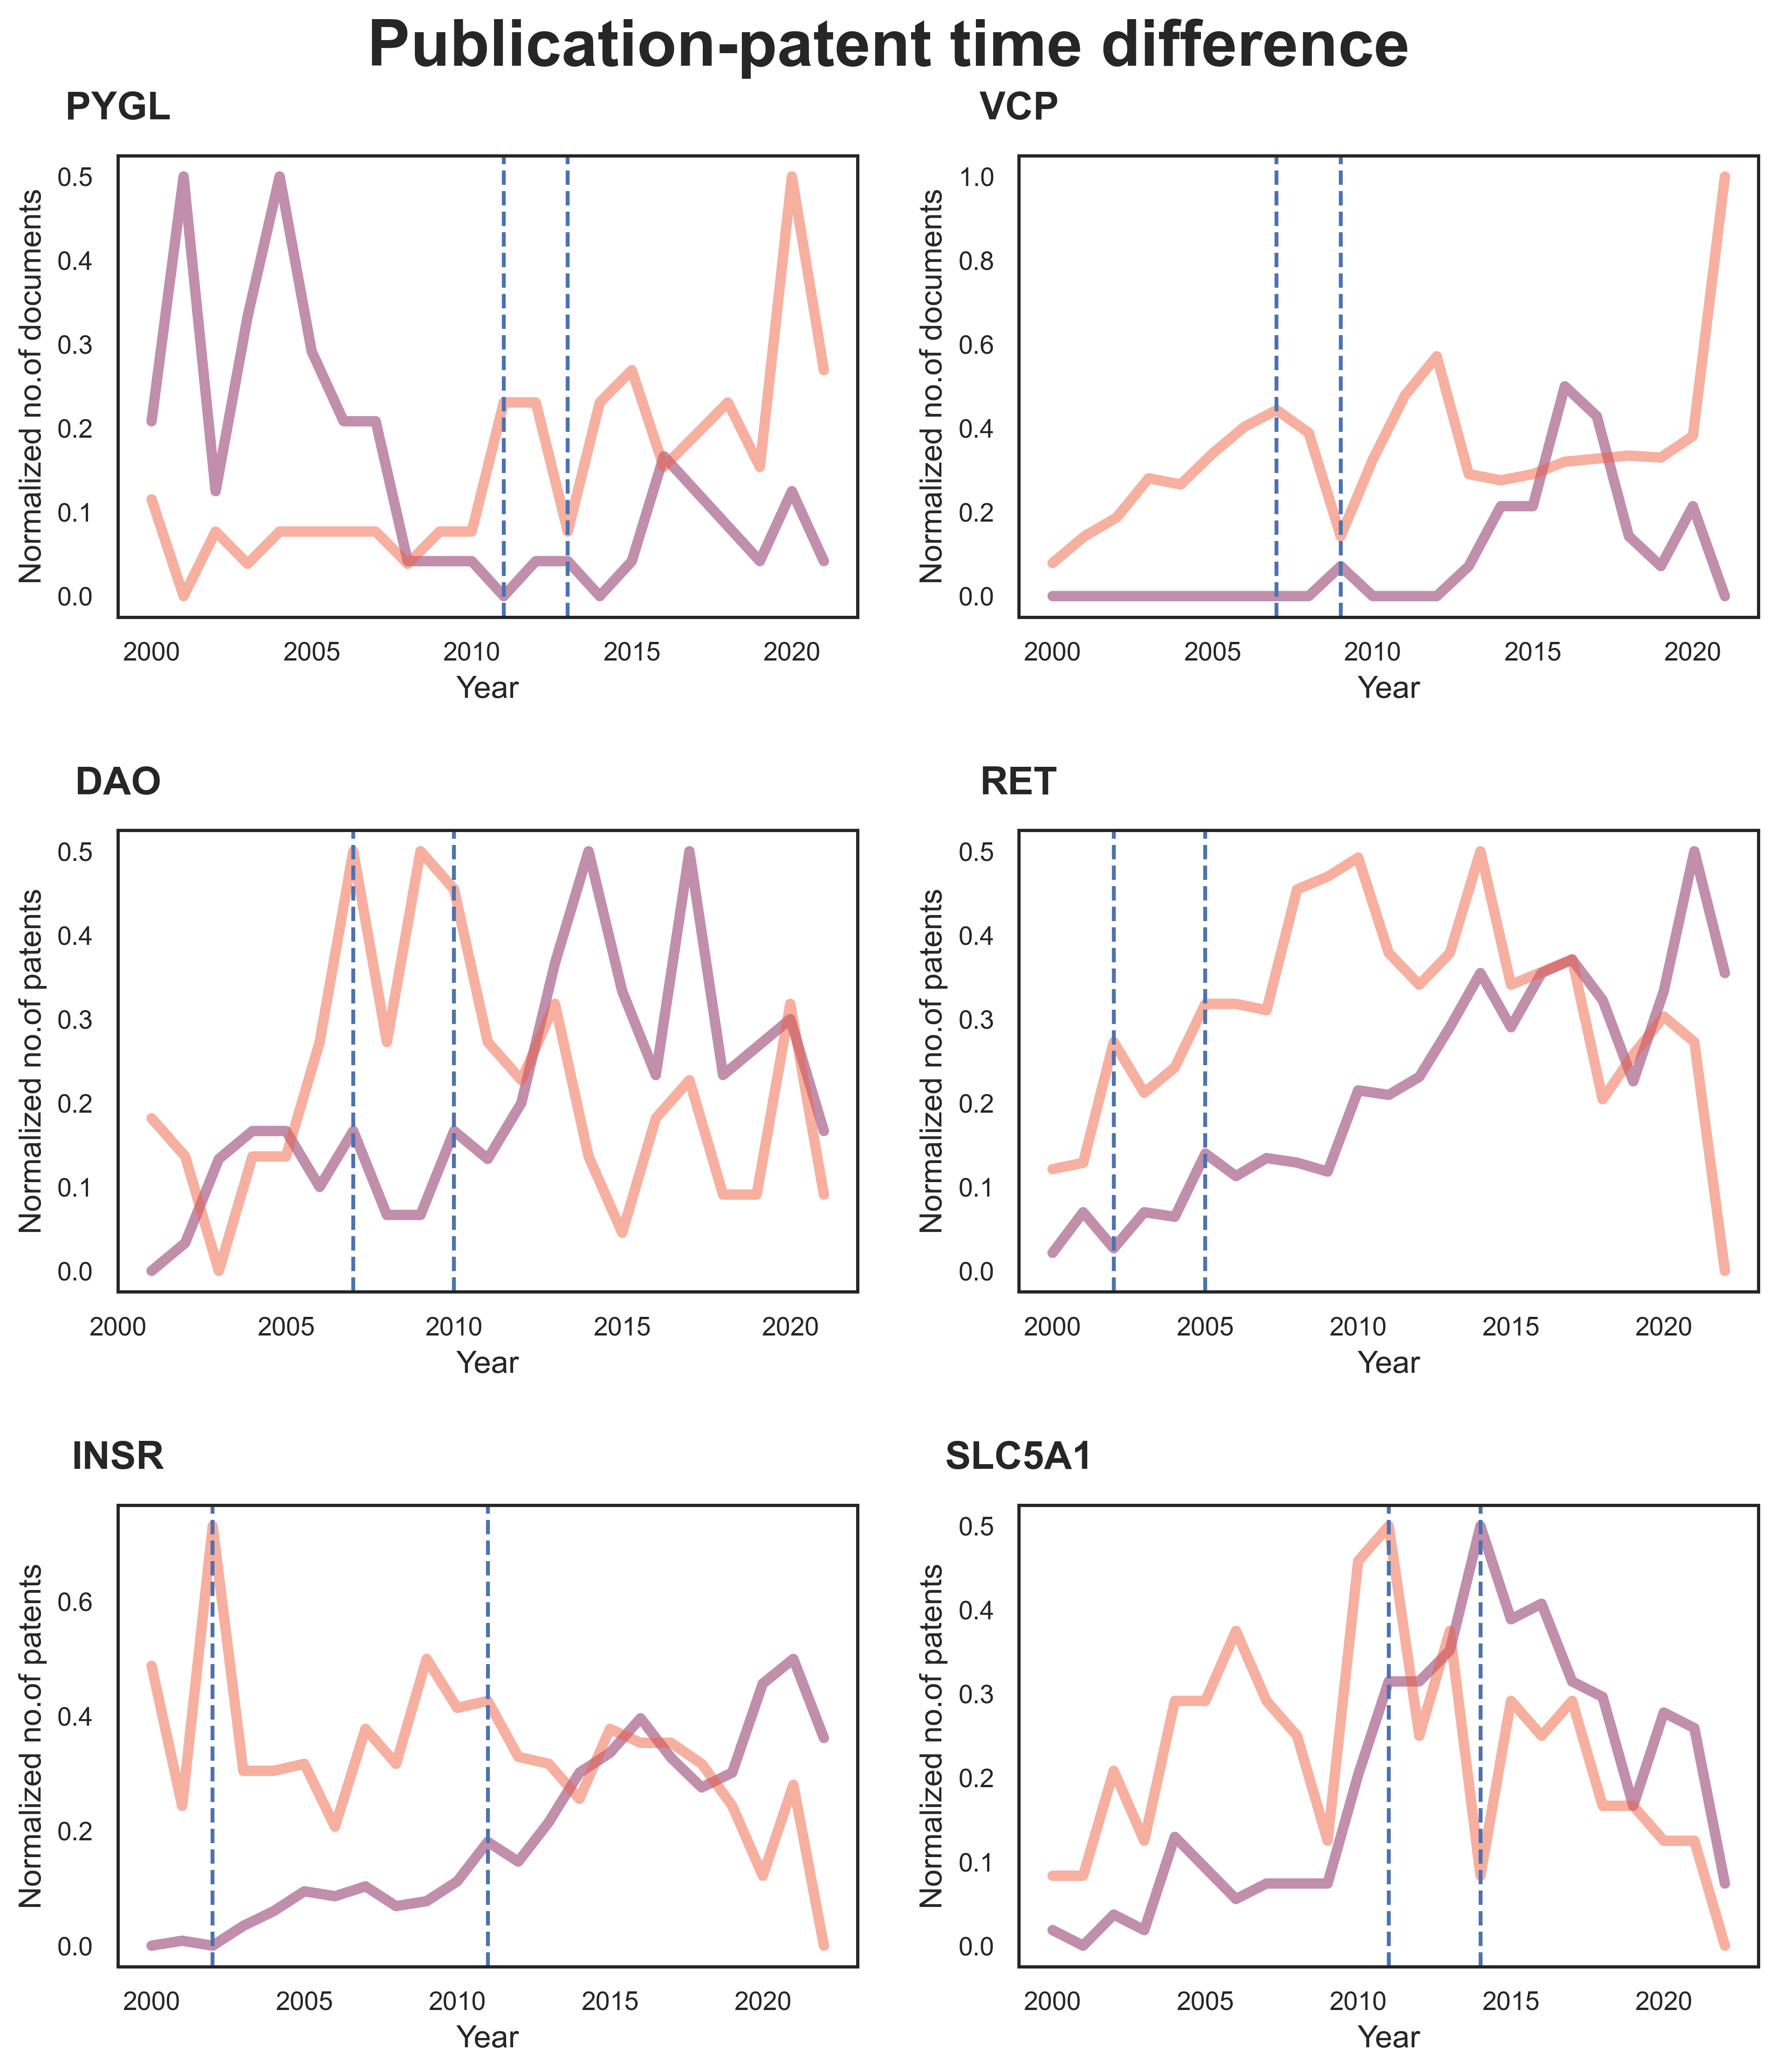

In [13]:
plt.figure(figsize=(10, 15))

plt.subplots_adjust(wspace=0)

subtitle = plt.suptitle(
    'Publication-patent time difference', 
    y=0.96,
    fontweight='bold',
    fontsize=25
)

"""PYGL"""
plt.subplot(4,2,1)
sns.lineplot(
    data=gene_dict['PYGL'], x='year', y='count',
    hue='source', palette='rocket', linewidth=4, errorbar=None,
    hue_order=['Patent', 'Publication'],  alpha=0.5, legend=False
)
plt.xlabel('Year', size=12)
plt.ylabel('Normalized no.of documents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(2011, ls='--')
plt.axvline(2013, ls='--')
plt.text(0, 1.1, 'PYGL',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

"""VCP"""
plt.subplot(4,2,2)
sns.lineplot(
    data=gene_dict['VCP'], x='year', y='count',
    hue='source', palette='rocket', linewidth=4, errorbar=None,
    hue_order=['Patent', 'Publication'],  alpha=0.5, legend=False
)
plt.xlabel('Year', size=12)
plt.ylabel('Normalized no.of documents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(2007, ls='--')
plt.axvline(2009, ls='--')
plt.text(0, 1.1, 'VCP',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

"""DAO"""
plt.subplot(4,2,3)
sns.lineplot(
    data=gene_dict['DAO'], x='year', y='count',
    hue='source', palette='rocket', linewidth=4, errorbar=None,
    hue_order=['Patent', 'Publication'], alpha=0.5, legend=False
)
plt.xlabel('Year', size=12)
plt.ylabel('Normalized no.of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(2007, ls='--')
plt.axvline(2010, ls='--')
plt.text(0, 1.1, 'DAO',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

"""RET"""
plt.subplot(4,2,4)
sns.lineplot(
    data=gene_dict['RET'], x='year', y='count',
    hue='source', linewidth=4, errorbar=None, palette='rocket',
    hue_order=['Patent', 'Publication'],  alpha=0.5, legend=False
)
plt.xlabel('Year', size=12)
plt.ylabel('Normalized no.of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(2002, ls='--')
plt.axvline(2005, ls='--')
plt.text(0, 1.1, 'RET',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

"""INSR"""
plt.subplot(4,2,5)
sns.lineplot(
    data=gene_dict['INSR'], x='year', y='count',
    hue='source', linewidth=4, errorbar=None, palette='rocket',
    hue_order=['Patent', 'Publication'],  alpha=0.5, legend=False
)
plt.xlabel('Year', size=12)
plt.ylabel('Normalized no.of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(2002, ls='--')
plt.axvline(2011, ls='--')
plt.text(0, 1.1, 'INSR',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

"""SLC5A1"""
plt.subplot(4,2,6)
sns.lineplot(
    data=gene_dict['SLC5A1'], x='year', y='count',
    hue='source', palette='rocket', linewidth=4, errorbar=None,
    hue_order=['Patent', 'Publication'],  alpha=0.5, legend=False
)
plt.xlabel('Year', size=12)
plt.ylabel('Normalized no.of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(2011, ls='--')
plt.axvline(2014, ls='--')
plt.text(0, 1.1, 'SLC5A1',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.tight_layout(pad=2.0)

plt.savefig(
    f'{FIG_DIR}/supplementary_figure_4.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()